<a href="https://colab.research.google.com/github/ngocmink/practical_RL/blob/main/week03_model_free/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install -q gymnasium[classic-control]

import os
import sys
import pandas as pd
from IPython.display import clear_output

import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import clear_output
from tqdm import tqdm, trange

%matplotlib inline

SEED = 42

if "google.colab" in sys.modules and not os.path.exists(".setup_complete"):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ["DISPLAY"] = ":1"


def moving_average(x, span=100):
    return pd.DataFrame({"x": np.asarray(x)}).x.ewm(span=span).mean().values


def seed_everything(env, seed=None):
    if seed is None:
        seed = SEED
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    env.reset(seed=seed)


def visualize_agent(env, agent, max_steps=100, delay=0.1):
    """
    Visualize the agent's behavior in the environment.

    Args:
        env: The environment
        agent: The trained agent
        max_steps: Maximum number of steps to take
        delay: Time delay between steps for visualization
    """
    s, _ = env.reset()
    total_reward = 0

    for step in range(max_steps):
        # Render the environment
        clear_output(True)
        plt.figure(figsize=(8, 6))
        plt.imshow(env.render())
        plt.title(f"Step: {step}, Total Reward: {total_reward:.2f}")
        plt.axis("off")
        plt.show()

        # Get action from the agent
        a = agent.get_best_action(s)  # Use best action for visualization

        # Take a step in the environment
        next_s, r, done, _, _ = env.step(a)

        # Update state and reward
        s = next_s
        total_reward += r

        # Add delay for better visualization
        time.sleep(delay)

        if done:
            # Show final state
            clear_output(True)
            plt.figure(figsize=(8, 6))
            plt.imshow(env.render())
            plt.title(f"Final State - Steps: {step + 1}, Total Reward: {total_reward:.2f}")
            plt.axis("off")
            plt.show()
            break


def benchmark_agents(
    exp_setups,
    num_episodes=1000,
    plot_every=100,
    t_max=10000,
    span=100,
    patch_every=None,
    patch_foo=None,
    num_seeds=3,
):
    all_rewards = {}
    envs = {exp_setup["name"]: exp_setup["env"]() for exp_setup in exp_setups}
    agents_buiders = {exp_setup["name"]: exp_setup["agent_builder"] for exp_setup in exp_setups}
    train_foo = {exp_setup["name"]: exp_setup["train_foo"] for exp_setup in exp_setups}

    for seed in range(num_seeds):
        SEED = seed + 42  # Using different seeds
        agents = {agent_name: agent() for agent_name, agent in agents_buiders.items()}

        # Create a separate environment for each agent using the env function
        for agent_name, agent in agents.items():
            agents[agent_name].env = envs[agent_name]

        seed_rewards = {agent_name: [] for agent_name in agents_buiders}

        # Seed each environment separately
        for agent_name in agents:
            seed_everything(envs[agent_name], seed=SEED)

        tbar = trange(num_episodes)
        tbar.set_description(f"Seed {seed + 1}/{num_seeds}")
        for i in tbar:
            for agent_name, agent in agents.items():
                seed_rewards[agent_name].append(train_foo[agent_name](envs[agent_name], agent))
            if i % 10 == 0:
                tbar.set_postfix({agent_name: seed_rewards[agent_name][-1] for agent_name in agents}, refresh=True)

        # Store rewards for this seed
        for agent_name, rewards_list in seed_rewards.items():
            if agent_name not in all_rewards:
                all_rewards[agent_name] = []
            all_rewards[agent_name].append(rewards_list)

        # Average rewards across seeds
        avg_rewards = {
            agent_name: np.mean(np.array(seed_results), axis=0) for agent_name, seed_results in all_rewards.items()
        }

        # Calculate standard deviation for confidence intervals
        std_rewards = {
            agent_name: np.std(np.array(seed_results), axis=0) for agent_name, seed_results in all_rewards.items()
        }

        # Plot average performance across seeds with confidence tubes
        clear_output(True)
        plt.figure(figsize=(10, 6))
        for agent_name, rewards_list in avg_rewards.items():
            mean_rewards = moving_average(rewards_list, span=span)
            std_rewards_smoothed = moving_average(std_rewards[agent_name], span=span)

            # Plot mean line
            plt.plot(mean_rewards, label=f"{agent_name} (avg of {num_seeds} seeds)")

            # Plot confidence tubes (mean ± std)
            plt.fill_between(
                range(len(mean_rewards)),
                mean_rewards - std_rewards_smoothed,
                mean_rewards + std_rewards_smoothed,
                alpha=0.2,
            )

            # Draw solid contour lines for the confidence tube borders
            plt.plot(range(len(mean_rewards)), mean_rewards - std_rewards_smoothed, "--", color="gray", alpha=0.7)
            plt.plot(range(len(mean_rewards)), mean_rewards + std_rewards_smoothed, "--", color="gray", alpha=0.7)

        plt.title(
            f"{envs[list(envs.keys())[0]].spec.id} - Average performance across {num_seeds} seeds with confidence intervals"
        )
        plt.legend()
        plt.show()

    return avg_rewards

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Starting virtual X frame buffer: Xvfb.


## Seminar: Q-learning

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

**Tip**: To ensure reproducibility, use the environment’s built-in random generator.

In [2]:
import math
import random
from collections import defaultdict

import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, env):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly.
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.env = env
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_legal_actions(self, _state):
        return list(range(self.env.action_space.n))

    def get_qvalue(self, state, action):
        """Returns Q(state,action)"""
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """Sets the Qvalue for [state,action] to the given value"""
        self._qvalues[state][action] = value

    # ---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        # <YOUR CODE HERE>
        value = max(self.get_qvalue(state, action) for action in possible_actions)

        # </END OF YOUR CODE>

        return value

    def update(self, state, action, reward, next_state, *args, **kwargs):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        # <YOUR CODE HERE>
        new_q_value = self.get_qvalue(state, action) + learning_rate * (reward + gamma * self.get_value(next_state) - self.get_qvalue(state, action))

        # </END OF YOUR CODE>

        self.set_qvalue(state, action, new_q_value)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # <YOUR CODE HERE>
        max = -999999
        for action in possible_actions:
          if(max < self.get_qvalue(state, action)):
            max = self.get_qvalue(state, action)
            best_action = action

        # </END OF YOUR CODE>

        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list).
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        # Tip: Use self.env.np_random.random() to generate a random number
        # <YOUR CODE HERE>
        rand = self.env.np_random.random()
        if(rand < epsilon):
          chosen_action = np.random.choice(possible_actions)
        else:
          chosen_action = self.get_best_action(state)

        # </END OF YOUR CODE>

        return chosen_action

### Try it on taxi

Here we use the Q-Learning agent on the Taxi-v3 environment from OpenAI gym.
You will need to complete a few of its functions.

In [3]:
import gymnasium as gym

env = gym.make("Taxi-v3", render_mode="rgb_array")

n_actions = env.action_space.n

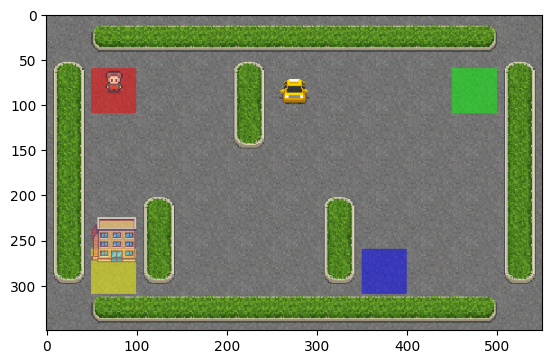

In [4]:
s, _ = env.reset(seed=3)
plt.imshow(env.render())

In [5]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s, _ = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        # <YOUR CODE HERE>
        a = agent.get_action(s)

        # </END OF YOUR CODE>

        next_s, r, terminated, truncated, _ = env.step(a)
        done = terminated
        # train (update) agent for state s
        # <YOUR CODE HERE>
        agent.update(s, a, r, next_s)

        # </END OF YOUR CODE>

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

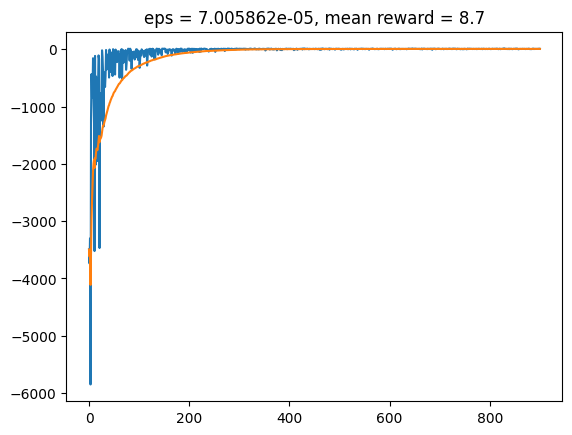

In [6]:
from IPython.display import clear_output

agent = QLearningAgent(alpha=0.5, epsilon=0.6, discount=0.99, env=env)

rewards = []
seed_everything(env)

for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        plt.title("eps = {:e}, mean reward = {:.1f}".format(agent.epsilon, np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.plot(moving_average(rewards))
        plt.show()

assert env.unwrapped.spec.id == "Taxi-v3" and np.mean(rewards[-100:]) >= 4.5, (
    "Please make sure that your agent is able to learn the optimal policy"
)

# Seminar: Discretized state spaces

Use agent to train efficiently on `CartPole-v0`. This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use `round(x, n_digits)` (or `np.round`) to round a real number to a given amount of digits. The tricky part is to get the `n_digits` right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

first state: [-0.03445876 -0.02280934 -0.01025561  0.0360914 ]


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


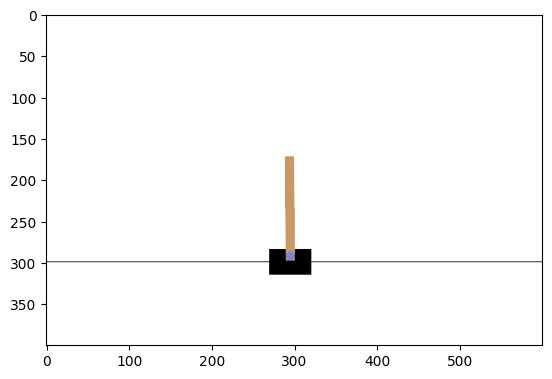

In [7]:
def make_env():
    return gym.make("CartPole-v0", render_mode="rgb_array").env  # .env unwraps the TimeLimit wrapper


env = make_env()
n_actions = env.action_space.n

print("first state: %s" % (env.reset()[0]))
plt.imshow(env.render())

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

In [8]:
def visualize_cartpole_observation_distribution(seen_observations):
    seen_observations = np.array(seen_observations)

    # The meaning of the observations is documented in
    # https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

    # Get the number of dimensions from the state
    n_dims = seen_observations.shape[1]

    f, axarr = plt.subplots(1, n_dims, figsize=(16, 4), sharey=True)
    titles = ["Cart Position", "Cart Velocity", "Pole Angle", "Pole Velocity At Tip"]

    for i in range(n_dims):
        ax = axarr[i]
        ax.hist(seen_observations[:, i], bins=20)
        ax.set_title(titles[i])
        xmin, xmax = ax.get_xlim()
        ax.set_xlim(min(xmin, -xmax), max(-xmin, xmax))
        ax.grid()
    f.tight_layout()

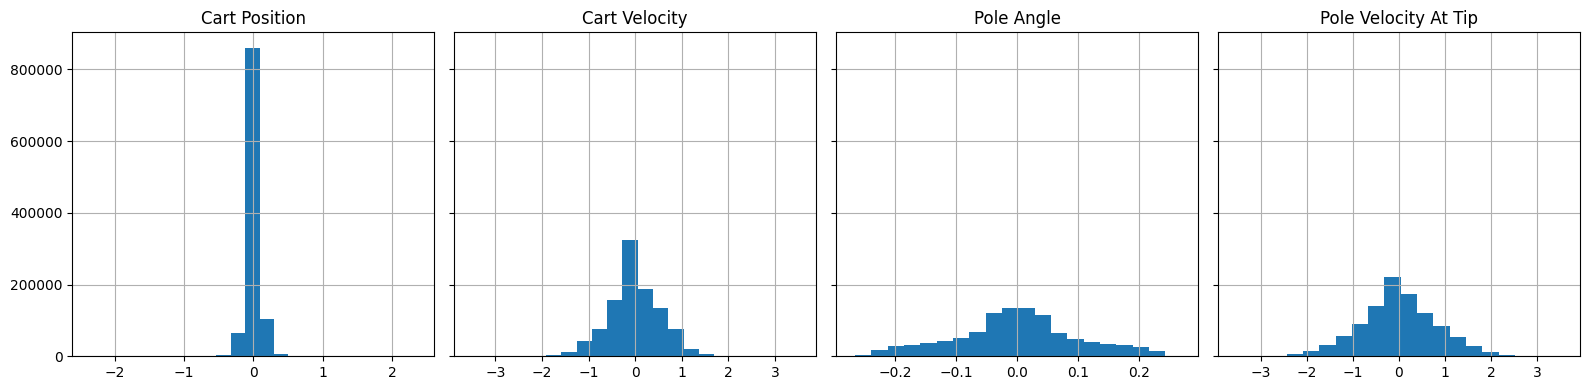

In [9]:
def gather_samples(env, max_steps=1000000):
    seen_observations = []
    total_steps = 0

    while total_steps < max_steps:
        s, _ = env.reset()
        seen_observations.append(s)
        done = False

        while not done and total_steps < max_steps:
            s, r, done, _, _ = env.step(env.action_space.sample())
            seen_observations.append(s)
            total_steps += 1

        if total_steps >= max_steps:
            break

    return seen_observations


unwraped_env_samples = gather_samples(env)
visualize_cartpole_observation_distribution(unwraped_env_samples)

## Discretize environment

In [10]:
from gymnasium.core import ObservationWrapper


class Discretizer(ObservationWrapper):
    def __init__(self, env, n_digits):
        super().__init__(env)
        self.n_digits = n_digits

    def observation(self, state):
        # Hint: you can do that with round(x, n_digits).
        # You may pick a different n_digits for each dimension.

        # <YOUR CODE HERE>
        state = np.round(state, self.n_digits)

        # </END OF YOUR CODE>

        return tuple(state)  # tuple to make it hashable

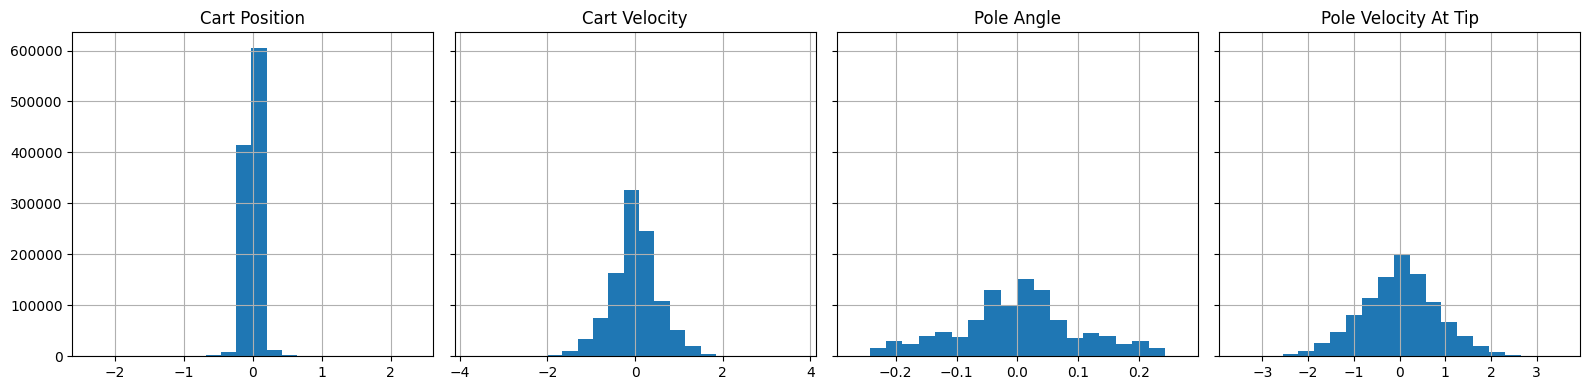

In [11]:
env = Discretizer(make_env(), n_digits=2)
seen_observations = gather_samples(env)
visualize_cartpole_observation_distribution(seen_observations)

## Learn discretized policy

Now let's train a policy that uses discretized state space.

__Tips:__

* Note that increasing the number of digits for one dimension of the observations increases your state space by a factor of $10$.
* If your discretization is too fine-grained, your agent will take much longer than 10000 steps to converge. You can either increase the number of iterations and reduce epsilon decay or change discretization. In practice we found that this kind of mistake is rather frequent.
* If your discretization is too coarse, your agent may fail to find the optimal policy. In practice we found that on this particular environment this kind of mistake is rare.
* **Start with a coarse discretization** and make it more fine-grained if that seems necessary.
* Having $10^3$–$10^4$ distinct states is recommended (`len(agent._qvalues)`), but not required.
* If things don't work without annealing $\varepsilon$, consider adding that, but make sure that it doesn't go to zero too quickly.

A reasonable agent should attain an average reward of at least 50.

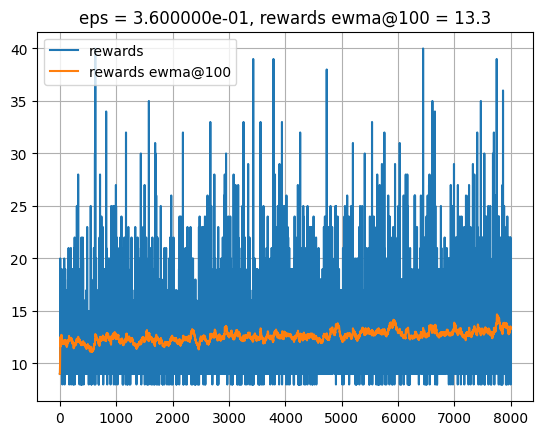

KeyboardInterrupt: 

In [12]:
agent = QLearningAgent(alpha=0.3, epsilon=0.36, discount=0.99, env=env)

rewards, epsilons = [], []
seed_everything(env)

for i in range(1000000):
    reward = play_and_train(env, agent, t_max=10**6)
    rewards.append(reward)
    epsilons.append(agent.epsilon)

    # OPTIONAL: <YOUR CODE: adjust epsilon>

    if i % 1000 == 0:
        rewards_ewma = moving_average(rewards)

        clear_output(True)
        plt.plot(rewards, label="rewards")
        plt.plot(rewards_ewma, label="rewards ewma@100")
        plt.legend()
        plt.grid()
        plt.title("eps = {:e}, rewards ewma@100 = {:.1f}".format(agent.epsilon, rewards_ewma[-1]))
        plt.show()

## Homework Part I: On-policy learning and SARSA (3 points)

The policy we're gonna use is epsilon-greedy policy, where agent takes the optimal action with probability $(1-\epsilon)$, otherwise samples action at random. Note that agent __can__ occasionally sample optimal action during random sampling by pure chance.

Now we gonna implement Expected Value SARSA on top of it.

In [28]:
class EVSarsaAgent(QLearningAgent):
    """
    An agent that changes some of q-learning functions to implement Expected Value SARSA.
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """

    def get_value(self, state):
        """
        Returns Vpi for current state under epsilon-greedy policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}

        Hint: all other methods from QLearningAgent are still accessible.
        """
        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)
        state_value = 0

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        # <YOUR CODE HERE>
        for action in possible_actions:
          if action == self.get_best_action(state):
            state_value += self.get_qvalue(state, action) * (1 - self.epsilon + self.epsilon / len(possible_actions))
          else:
            state_value += self.get_qvalue(state, action) * self.epsilon / len(possible_actions)
        # </END OF YOUR CODE>

        return state_value

### Cliff World

Let's now see how our algorithm compares against q-learning in case where we force agent to explore all the time.

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/cliffworld.png width=600>
<center><i>Image from CS188</i></center>

In [29]:
import gymnasium as gym

env = gym.make("CliffWalking-v1", render_mode="rgb_array")
n_actions = env.action_space.n

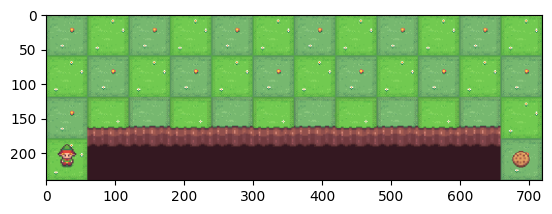

In [30]:
# Our cliffworld has one difference from what's in the image: there is no wall.
# Agent can choose to go as close to the cliff as it wishes.
# x:start, T:exit, C:cliff, o: flat ground

env.reset()
plt.imshow(env.render())

EVSARSA mean reward = -31.17
QLEARNING mean reward = -61.22


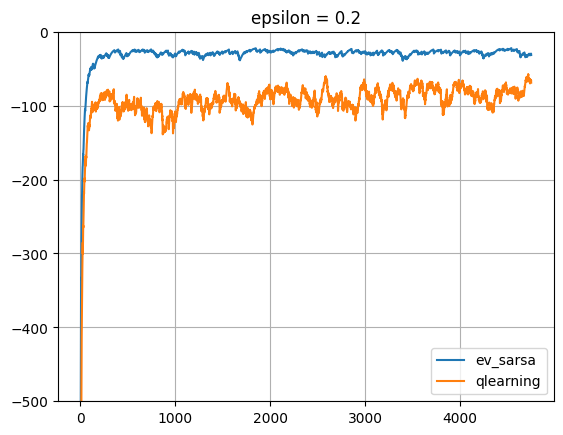

In [31]:
from IPython.display import clear_output

seed_everything(env)

agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99, env=env)

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99, env=env)

rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 250 == 0:
        clear_output(True)
        print("EVSARSA mean reward =", np.mean(rewards_sarsa[-100:]))
        print("QLEARNING mean reward =", np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label="ev_sarsa")
        plt.plot(moving_average(rewards_ql), label="qlearning")
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

Let's now see what did the algorithms learn by visualizing their actions at every state.

In [32]:
def get_ascii_policy(agent):
    """Returns CliffWalkingEnv policy with arrows as a string. Hard-coded."""

    env = gym.make("CliffWalking-v1", render_mode="ansi")
    env.reset()
    grid = [x.split("  ") for x in env.render().split("\n")[:4]]

    n_rows, n_cols = 4, 12
    start_state_index = 36
    actions = "^>v<"

    policy_str = ""
    for yi in range(n_rows):
        for xi in range(n_cols):
            if grid[yi][xi] == "C":
                policy_str += " C "
            elif (yi * n_cols + xi) == start_state_index:
                policy_str += " X "
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                policy_str += " T "
            else:
                policy_str += " %s " % actions[agent.get_best_action(yi * n_cols + xi)]
        policy_str += "\n"

    return policy_str


def draw_policy(agent):
    """Prints CliffWalkingEnv policy with arrows."""
    print(get_ascii_policy(agent))

In [33]:
print("Q-Learning")
draw_policy(agent_ql)

print("SARSA")
draw_policy(agent_sarsa)

Q-Learning
 >  >  >  >  v  >  v  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 

SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 



In [34]:
sarsa_near_cliff_row = get_ascii_policy(agent_sarsa).strip().split("\n")[-2].strip().split()[1:-3]
assert all(action == "^" for action in sarsa_near_cliff_row), (
    "SARSA policy should have '^' actions in the row near the cliff"
)

qlearning_near_cliff_row = get_ascii_policy(agent_ql).strip().split("\n")[-2].strip().split()[1:-3]
assert all(action == ">" for action in qlearning_near_cliff_row), (
    "Q-learning policy should have '>' actions in the row near the cliff"
)

## Expected Value SARSA for softmax policy (2 points)

Implement an agent that would use a softmax policy for getting an action. Do not forget to also use softmax when calculating the expected value for value estimation. Draw the policy of the agent and see if the result is different compared to the previous approaches. Also, try using different temperatures ($\tau$) and compare the results.

$$ \pi(a_i \mid s) = \operatorname{softmax} \left( \left\{ {Q(s, a_j) \over \tau} \right\}_{j=1}^n \right)_i = {\operatorname{exp} \left( Q(s,a_i) / \tau \right)  \over {\sum_{j}  \operatorname{exp} \left( Q(s,a_j) / \tau  \right)}} $$

In [78]:
from scipy.special import softmax


class SoftmaxEVSarsaAgent(EVSarsaAgent):
    def __init__(self, alpha, tau, discount, env):
        super().__init__(alpha, None, discount, env)
        assert tau > 0
        self.tau = tau

    def get_value(self, state):
        """
        Returns V_{pi} for current state under softmax policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}

        Hint: all other methods from QLearningAgent are still accessible.
        """
        possible_actions = self.get_legal_actions(state)
        value = 0
        policy = {}
        sum = 0

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        # <YOUR CODE HERE>
        for action in possible_actions:
          sum += np.exp(self.get_qvalue(state, action) / self.tau)
        for action in possible_actions:
          policy[action] = np.exp(self.get_qvalue(state, action) / self.tau) / sum

        for action in possible_actions:
            value += policy[action] * self.get_qvalue(state, action)
        # </END OF YOUR CODE>

        return value

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.
        We should take a random action with probability equaled softmax of q values.
        """
        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None
        policy = {}
        sum = 0

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # Tip: Use self.env.np_random.random() to generate a random number
        # <YOUR CODE HERE>
        for action in possible_actions:
          sum += np.exp(self.get_qvalue(state, action) / self.tau)
        for action in possible_actions:
          policy[action] = np.exp(self.get_qvalue(state, action) / self.tau) / sum

        n = self.env.np_random.random()
        for action in possible_actions:
          if n < policy[action]:
            action = action
            break
          else:
            n -= policy[action]
        # action = np.random.choice(list(policy.keys()), p=list(policy.values()))

        # </END OF YOUR CODE>

        return action

EVSARSA mean reward = -28.14
SOFTMAX_EVSARSA mean reward = -14.43
QLEARNING mean reward = -89.83


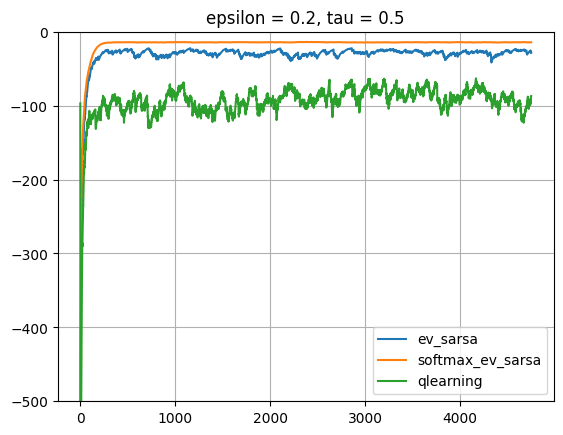

In [82]:
seed_everything(env)

agent_sarsa = EVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99, env=env)

agent_sarsa_softmax = SoftmaxEVSarsaAgent(alpha=0.25, tau=0.5, discount=0.99, env=env)

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99, env=env)

rewards_sarsa, rewards_sarsa_softmax, rewards_ql = [], [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_sarsa_softmax.append(play_and_train(env, agent_sarsa_softmax))
    rewards_ql.append(play_and_train(env, agent_ql))

    if i % 250 == 0:
        clear_output(True)
        print("EVSARSA mean reward =", np.mean(rewards_sarsa[-100:]))
        print("SOFTMAX_EVSARSA mean reward =", np.mean(rewards_sarsa_softmax[-100:]))
        print("QLEARNING mean reward =", np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s, tau = %s" % (agent_ql.epsilon, agent_sarsa_softmax.tau))
        plt.plot(moving_average(rewards_sarsa), label="ev_sarsa")
        plt.plot(moving_average(rewards_sarsa_softmax), label="softmax_ev_sarsa")
        plt.plot(moving_average(rewards_ql), label="qlearning")
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

In [84]:
print("Q-Learning")
draw_policy(agent_ql)

print("SARSA")
draw_policy(agent_sarsa)

print("SOFTMAX SARSA")
draw_policy(agent_sarsa_softmax)

Q-Learning
 v  >  v  >  v  >  v  v  >  v  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 

SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 

SOFTMAX SARSA
 v  >  >  >  >  >  v  >  >  v  v  v 
 >  >  >  >  >  >  >  >  >  v  v  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 



In [81]:
qlearning_near_cliff_row = get_ascii_policy(agent_sarsa_softmax).strip().split("\n")[-2].strip().split()[1:-3]
assert all(action == ">" for action in qlearning_near_cliff_row), (
    "Softmax SARSA policy should have '>' actions in the row near the cliff"
)

### More on SARSA

Here are some of the things you can do if you feel like it:

* Play with epsilon. See learned how policies change if you set epsilon to higher/lower values (e.g. 0.75).
* Implement N-step algorithms and TD($\lambda$): see [Sutton's book](http://incompleteideas.net/book/RLbook2020.pdf) chapter 7 and chapter 12.
* Use those algorithms to train on CartPole in previous / next assignment for this week.

## Part II: experience replay (2 points)

There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: [spoiler] Experience replay :)

The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=480>

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer.
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [ ]:
from IPython.display import clear_output

In [ ]:
import random


class ReplayBuffer(object):
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self._storage = []
        self._maxsize = size

        # OPTIONAL: YOUR CODE

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        """
        Make sure, _storage will not exceed _maxsize.
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        """
        data = (obs_t, action, reward, obs_tp1, done)

        # add data to storage
        # <YOUR CODE HERE>

        # </END OF YOUR CODE>

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """

        # <YOUR CODE HERE>
        idxes = <YOUR CODE: randomly generate batch_size integers to be used as indexes of samples>
        # collect <s,a,r,s',done> for each index
        return (
            np.array( <YOUR CODE: states> ),
            np.array( <YOUR CODE: actions> ),
            np.array( <YOUR CODE: rewards> ),
            np.array( <YOUR CODE: next_states> ),
            np.array( <YOUR CODE: is_done>,
        )

        # </END OF YOUR CODE>

Some tests to make sure your buffer works right

In [ ]:
def obj2arrays(obj):
    for x in obj:
        yield np.array([x])


def obj2sampled(obj):
    return tuple(obj2arrays(obj))


replay = ReplayBuffer(2)
obj1 = (0, 1, 2, 3, True)
obj2 = (4, 5, 6, 7, False)
replay.add(*obj1)
assert replay.sample(1) == obj2sampled(obj1), (
    "If there's just one object in buffer, it must be retrieved by buf.sample(1)"
)
replay.add(*obj2)
assert len(replay) == 2, "Please make sure __len__ methods works as intended."
replay.add(*obj2)
assert len(replay) == 2, "When buffer is at max capacity, replace objects instead of adding new ones."
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2sampled(obj2)
replay.add(*obj1)
assert max(len(np.unique(a)) for a in replay.sample(100)) == 2
replay.add(*obj1)
assert tuple(np.unique(a) for a in replay.sample(100)) == obj2sampled(obj1)
print("Success!")

Success!


Now let's use this buffer to improve training:

In [ ]:
import gymnasium as gym

env = gym.make("Taxi-v3")
# env = Discretizer(gym.make("CartPole-v1", render_mode="rgb_array"), n_digits=2)
n_actions = env.action_space.n

In [ ]:
def play_and_train_with_replay(env, agent, replay=None, t_max=10**4, replay_batch_size=32):
    """
    This function should
    - run a full game, actions given by agent.get_action(s)
    - train agent using agent.update(...) whenever possible
    - return total reward
    :param replay: ReplayBuffer where agent can store and sample (s,a,r,s',done) tuples.
        If None, do not use experience replay
    """
    total_reward = 0.0
    s, _ = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s
        # <YOUR CODE HERE>
        a =

        # </END OF YOUR CODE>

        next_s, r, done, trunc, _ = env.step(a)

        # update agent on current transition. Use agent.update
        # <YOUR CODE HERE>

        # </END OF YOUR CODE>

        if replay is not None:
            # store current <s,a,r,s'> transition in buffer
            # <YOUR CODE HERE>

            # </END OF YOUR CODE>

            # sample replay_batch_size random transitions from replay,
            # then update agent on each of them in a loop
            s_, a_, r_, next_s_, done_ = replay.sample(replay_batch_size)
            for i in range(replay_batch_size):
                # <YOUR CODE HERE>
                agent.update()

                # </END OF YOUR CODE>

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [ ]:
# Create two agents: first will use experience replay, second will not.

agent_baseline = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99, env=env)

agent_replay = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99, env=env)

replay = ReplayBuffer(1000)

Baseline : eps = 2.9191091959171894e-05 mean reward = 6.0
ExpReplay: eps = 2.9191091959171894e-05 mean reward = 7.4


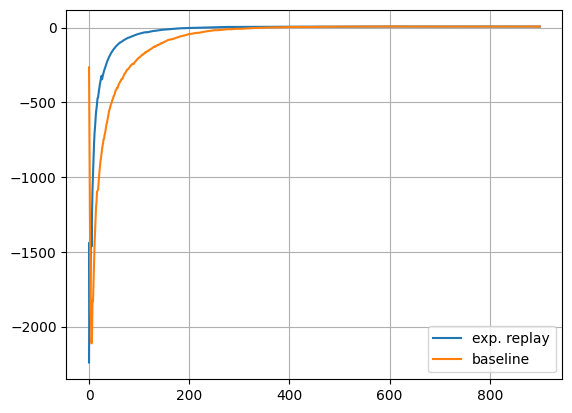

In [ ]:
import pandas as pd
from IPython.display import clear_output


def moving_average(x, span=100):
    return pd.DataFrame({"x": np.asarray(x)}).x.ewm(span=span).mean().values


rewards_replay, rewards_baseline = [], []

for i in range(1000):
    rewards_replay.append(play_and_train_with_replay(env, agent_replay, replay))
    rewards_baseline.append(play_and_train_with_replay(env, agent_baseline, replay=None))

    agent_replay.epsilon *= 0.99
    agent_baseline.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        print(
            "Baseline : eps =",
            agent_replay.epsilon,
            "mean reward =",
            np.mean(rewards_baseline[-10:]),
        )
        print(
            "ExpReplay: eps =",
            agent_baseline.epsilon,
            "mean reward =",
            np.mean(rewards_replay[-10:]),
        )
        plt.plot(moving_average(rewards_replay), label="exp. replay")
        plt.plot(moving_average(rewards_baseline), label="baseline")
        plt.grid()
        plt.legend()
        plt.show()

assert np.array(rewards_replay[:200]).mean() > np.array(rewards_baseline[:200]).mean(), (
    "Experienced replay should improve performance"
)

#### What to expect:

Experience replay, if implemented correctly, will improve algorithm's initial convergence a lot, but it shouldn't affect the final performance.

If you're feeling that you need more examples to understand how experience replay works, try using it for discretized state spaces (CartPole or other __[classic control envs](https://gym.openai.com/envs/#classic_control)__).

# N-step TD learning

In this part, we will get acquainted with multi-step estimates. We will start with an on-policy setting, but as a bonus you can also implement the off-policy version.

Recall that TD(0) estimates have low variance but high bias, while full trajectory estimates have low bias but high variance. For many tasks, the optimal approach lies somewhere in between these extremes. N-step methods provide this middle ground by allowing us to control the bias-variance tradeoff through the choice of n.

**Practical note:** Analyzing performance with different n-step values can be difficult due to noisy rewards. In that case, use the benchmark_agents function, which can visualize multi-seed performance.

## N-step EV-SARSA (2 points)

Look at section 7.2 in Sutton Barto book: http://incompleteideas.net/book/the-book-2nd.html

Regular n-step TD (without episodic buffer):

For each step $t$ we take the future window $[t,t+n]$ (if available) and calculate the return:

$$G_t = r_t + \gamma r_{t+1} + \cdots + \gamma^{n-1} r_{t+n-1} + \gamma^n V(s_{t+n})$$

This is done from left to right (as data accumulates). If the episode ends earlier, we take the actual length of the remaining trajectory.

So,

---
### n-step Sarsa for estimating $Q \approx q_* \text{ or } q_\pi$

- Initialize $Q(s,a)$ arbitrarily, for all $s \in \mathcal{S}, a \in \mathcal{A}$.
- Initialize $\pi$ to be $\varepsilon$-greedy with respect to $Q$, or to a fixed given policy.
- Algorithm parameters: step size $\alpha \in (0,1]$, small $\varepsilon > 0$, a positive integer $n$.
- All store and access operations (for $S_t$, $A_t$, and $R_t$) can take their index mod $n+1$.

For each episode:
- Initialize and store $S_0 \neq$ terminal.
- Select and store an action $A_0 \sim \pi(\cdot|S_0)$.
- $T \leftarrow \infty$

For $t = 0,1,2,\dots$:
- If $t < T$:
  - Take action $A_t$.
  - Observe and store the next reward as $R_{t+1}$ and the next state as $S_{t+1}$.
  - If $S_{t+1}$ is terminal, set $T \leftarrow t + 1$.
  - Else, select and store an action $A_{t+1} \sim \pi(\cdot|S_{t+1})$.

- $\tau \leftarrow t - n + 1$ ($\tau$ is the time whose estimate is being updated).

- If $\tau \geq 0$:
  - $G \leftarrow \sum_{i=\tau+1}^{\min(\tau+n,T)} \gamma^{i-\tau-1} R_i$.
  - If $\tau + n < T$, then $G \leftarrow G + \gamma^n Q(S_{\tau+n}, A_{\tau+n}) \quad (G_{\tau:\tau+n})$.
  - $Q(S_\tau,A_\tau) \leftarrow Q(S_\tau,A_\tau) + \alpha[G - Q(S_\tau,A_\tau)]$.
  - If $\pi$ is being learned, ensure $\pi(\cdot|S_\tau)$ is $\varepsilon$-greedy wrt $Q$.

- If $\tau = T - 1$, break.

---

Since we are working with EVSARSA, we will have a small difference:

It consists of a linear string of sample actions and states, just as in *n*-step Sarsa, except that its last element is a branch over all action possibilities weighted, as always, by their probability under $\pi$. This algorithm can be described by the same equation as *n*-step Sarsa (above) except with the *n*-step return redefined as

$$
G_{t:t+n} \doteq R_{t+1} + \dots + \gamma^{n-1} R_{t+n} + \gamma^n \bar{V}_{t+n-1}(S_{t+n}),
\quad t + n < T,
$$

(with $ G_{t:t+n} \doteq G_t $ for $ t + n \geq T $ where $ \bar{V}_t(s) $ is the *expected approximate value* of state $ s $, using the estimated action values at time $ t $, under the target policy:

$$
\bar{V}_t(s) \doteq \sum_a \pi(a|s) Q_t(s, a), \quad \text{for all } s \in \mathcal{S}.
$$

Expected approximate values are used in developing many of the action-value methods in the rest of this book. If $ s $ is terminal, then its expected approximate value is defined to be 0.


In [ ]:
from collections import deque, namedtuple

Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])


class NStepEVSarsaAgent(EVSarsaAgent):
    def __init__(self, n_steps, *args, **kwargs):
        assert n_steps >= 1, "n_step must be greater than or equal to 1"
        super().__init__(*args, **kwargs)
        self.n_steps = n_steps
        self.t = 0  # aka current step
        self.T = sys.maxsize  # aka terminal step
        self.memory = []

    def update(self, state, action, reward, next_state, done):
        if len(self.memory) == 0:
            self.memory.append(Transition(state, action, reward, next_state, done))
            return

        if self.t < self.T:
            self.memory.append(Transition(state, action, reward, next_state, done))

            if done:
                self.T = self.t + 1

        tau = self.t - self.n_steps
        if tau >= 0:
            start_index, end_index = tau + 1, min(tau + self.n_steps, self.T)
            G = 0
            # <YOUR CODE HERE>
            G =

            # </END OF YOUR CODE>

            if tau + self.n_steps < self.T:
                next_s = self.memory[tau + self.n_steps].next_state
                if next_s is not None:
                    # <YOUR CODE HERE>
                    G =

                    # </END OF YOUR CODE>

            state_tau, action_tau = (
                self.memory[tau].state,
                self.memory[tau].action,
            )  # state and action to being updated

            # <YOUR CODE HERE>
            new_qvalue =

            # </END OF YOUR CODE>
            self.set_qvalue(state_tau, action_tau, new_qvalue)
        self.t += 1

        if self.t >= self.T and tau < self.T - 1:
            self.update(self.memory[self.T - 1].state, self.memory[self.T - 1].action, 0, None, True)

    def reset(self):
        self.memory = []
        self.t = 0
        self.T = sys.maxsize


def play_and_train_nstep(env, agent, t_max=10**4):
    """
    This function should
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s, _ = env.reset()
    agent.reset()

    for t in range(t_max):
        # get agent to pick action given state s
        a = agent.get_action(s)

        next_s, r, terminated, truncated, info = env.step(a)
        done = terminated

        # train (update) agent for state s
        agent.update(s, a, r, next_s, done)

        s = next_s
        total_reward += r
        if done:
            agent.reset()
            break

    return total_reward

In [ ]:
from functools import partial


def evaluate_nstep_evsarsa(env_builder, n_episodes=1000, t_max=10000, n_seeds=3, span=10):
    params = {"alpha": 0.1, "epsilon": 0.1, "discount": 0.99, "env": env_builder()}

    exp_setups = [
        {
            "name": f"nstep_evsarsa_{n_step}",
            "agent_builder": partial(NStepEVSarsaAgent, n_steps=n_step, **params),
            "env": env_builder,
            "train_foo": play_and_train_nstep,
        }
        for n_step in [1, 2, 4]
    ]
    _ = benchmark_agents(
        exp_setups, num_episodes=n_episodes, t_max=t_max, plot_every=1000, span=span, num_seeds=n_seeds
    )

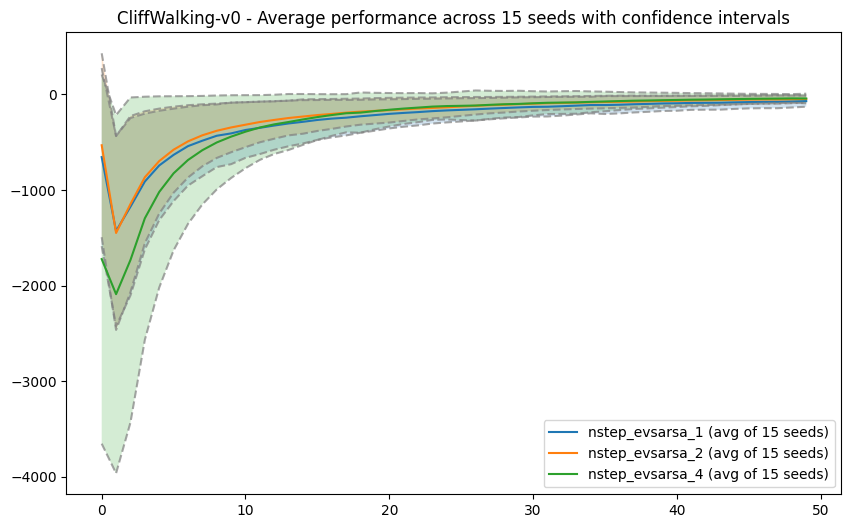

In [ ]:
evaluate_nstep_evsarsa(lambda: gym.make("CliffWalking-v0"), n_episodes=50, t_max=1000, n_seeds=15, span=25)

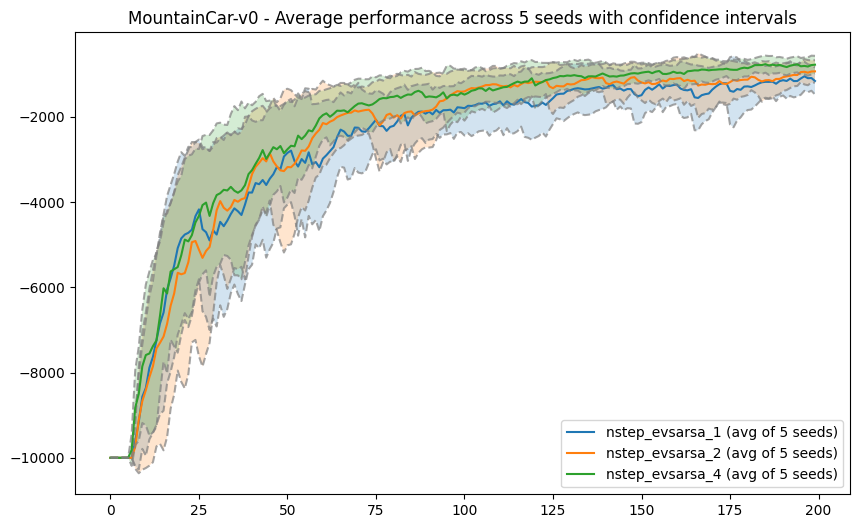

In [ ]:
evaluate_nstep_evsarsa(lambda: Discretizer(gym.make("MountainCar-v0"), n_digits=2), n_episodes=200, n_seeds=5)

## Eligibility traces: (1 point)

Eligibility traces are a mechanism that helps to assign credit to states and actions that occurred in the past, allowing for more efficient learning by updating multiple state-action pairs in a single step.

Typically, eligibility traces are implemented as decaying values for each state-action pair, with recent pairs having higher trace values than older ones. At the beginning of each episode, all eligibility traces are initialized to zero, and at the end of an episode, they are reset to prepare for the next learning sequence.

During each step, eligibility traces are updated by incrementing the value for the current state-action pair and applying a decay factor to all traces, allowing the algorithm to update all previously visited state-action pairs proportionally to their recency and relevance.


---

### Watkins($\lambda$) algorithm
**Initialize** $ Q(s, a) $ arbitrarily and $ e(s, a) = 0 $, for all $ s, a $.

**Repeat** (for each episode):

1. Initialize $ s, a $.
2. **Repeat** (for each step of episode):
   - Take action $ a $, observe $ r, s' $.
   - Choose $ a' $ from $ s' $ using policy derived from $ Q $ (e.g., $ \varepsilon $-greedy).
   - $ a^* \leftarrow \arg\max_b Q(s', b) $ (if $ a' $ ties for the max, then $ a^* \leftarrow a' $).
   - $ \delta \leftarrow r + \gamma Q(s', a^*) - Q(s, a) $.
   - $ e(s, a) \leftarrow e(s, a) + 1 $.
   - **For all** $ s, a $:
     - $ Q(s, a) \leftarrow Q(s, a) + \alpha \delta e(s, a) $.
     - If $ a' = a^* $, then $ e(s, a) \leftarrow \gamma \lambda e(s, a) $,  
       else $ e(s, a) \leftarrow 0 $.
   - $ s \leftarrow s' $; $ a \leftarrow a' $.

**until** $ s $ is terminal.

---

We have two policies: the target policy (greedy) and the behavior policy (ε-greedy).

Watkins' Q(λ) algorithm addresses the challenge of using eligibility traces in off-policy learning. The key insight is that we can only reliably update state-action pairs along a trajectory up to the point where we take a non-greedy action.

When we select an action a' that is also the greedy action a* (meaning our behavior and target policies align), we can continue propagating updates through the eligibility traces, decaying them by γλ as usual.

However, when we select a non-greedy action (a' ≠ a*), we must cut the eligibility traces to zero. This is because the future trajectory will follow the behavior policy, not the target policy we're trying to learn.

This approach ensures that Q-values are only updated based on sequences where the behavior matched the target policy, maintaining the validity of the off-policy updates while still benefiting from eligibility traces when possible.




In [ ]:
from collections import defaultdict


class QLambdaAgent(QLearningAgent):
    def __init__(self, alpha, epsilon, discount, lambda_factor, env):
        assert 0 <= lambda_factor <= 1, "lambda must be between 0 and 1"
        super().__init__(alpha, epsilon, discount, env)
        self.eligibility_trace = defaultdict(lambda: 0)
        self.lambda_factor = lambda_factor

    def reset(self):
        pass

    def update(self, state, action, reward, next_state, _done):
        """
        Implements Q(λ) update rule:
        - Updates Q-values using eligibility traces.
        - Adjusts traces based on whether the selected action matches the best action.
        """
        # Update eligibility traces
        for s, a in list(self.eligibility_trace.keys()):
            if action == self.get_best_action(state):
                # Decay eligibility trace (but never immediately zero it)
                # <YOUR CODE HERE>

                # </END OF YOUR CODE>
            else:
                # <YOUR CODE HERE>

                # </END OF YOUR CODE>

            # Remove traces close to zero
            if abs(self.eligibility_trace[(s, a)]) < 1e-6:
                del self.eligibility_trace[(s, a)]

        # Compute TD error with check for terminal state
        next_value = self.get_value(next_state) if next_state is not None else 0
        delta = reward + self.discount * next_value - self.get_qvalue(state, action)

        # Update eligibility trace for (state, action)
        # <YOUR CODE HERE>

        # </END OF YOUR CODE>

        # Iterate over all stored (s, a) pairs in eligibility trace
        for s, a in list(self.eligibility_trace.keys()):
            # <YOUR CODE HERE>
            new_qvalue =

            # </END OF YOUR CODE>
            self.set_qvalue(s, a, new_qvalue)

In [ ]:
from functools import partial


def evaluate_lambda_qlearning(env_builder, n_episodes=1000, t_max=10000, n_seeds=3, span=10):
    params = {"alpha": 0.1, "epsilon": 0.1, "discount": 0.99, "env": env_builder()}
    exp_setups = []
    exp_setups.extend(
        [
            {
                "name": f"lambda_qlearning_{lambda_factor}",
                "agent_builder": partial(QLambdaAgent, lambda_factor=lambda_factor, **params),
                "env": env_builder,
                "train_foo": play_and_train_nstep,
            }
            for lambda_factor in [0.0, 0.2, 0.5, 0.95]
        ]
    )
    _ = benchmark_agents(
        exp_setups, num_episodes=n_episodes, t_max=t_max, plot_every=1000, span=span, num_seeds=n_seeds
    )

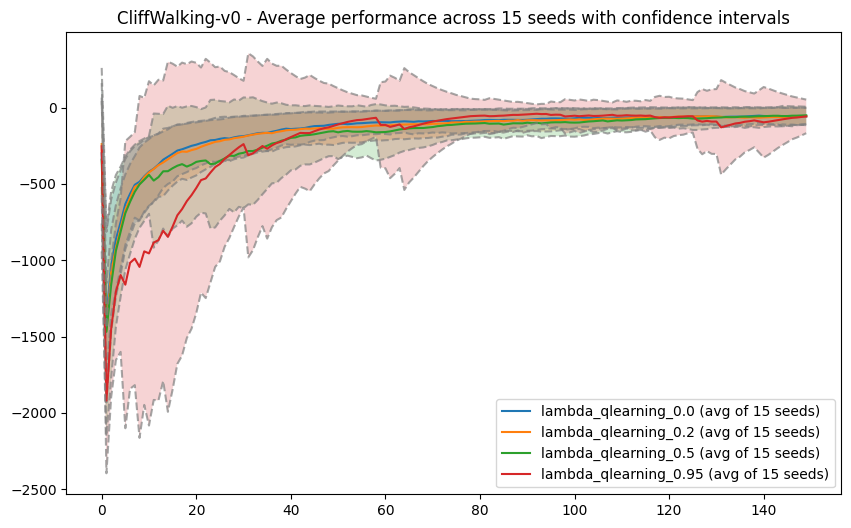

In [ ]:
evaluate_lambda_qlearning(lambda: gym.make("CliffWalking-v0"), n_episodes=150, t_max=1000, n_seeds=15, span=20)

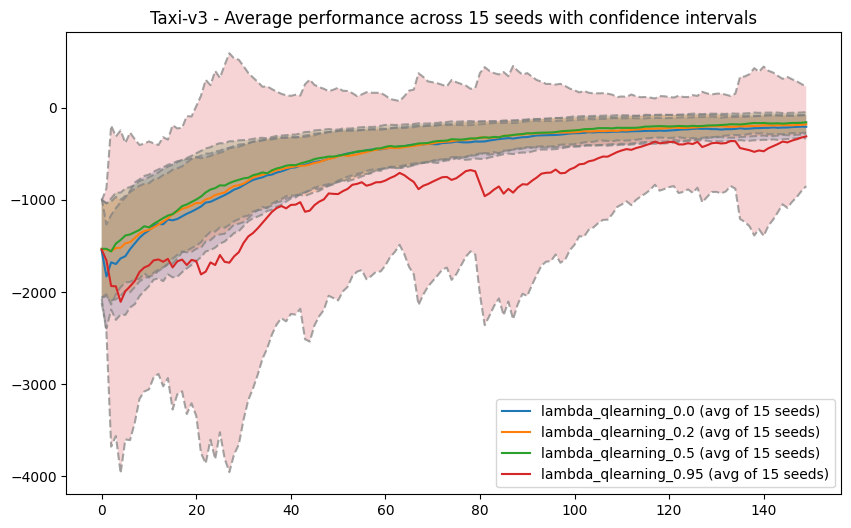

In [ ]:
evaluate_lambda_qlearning(lambda: gym.make("Taxi-v3"), n_episodes=150, t_max=1000, n_seeds=15, span=20)

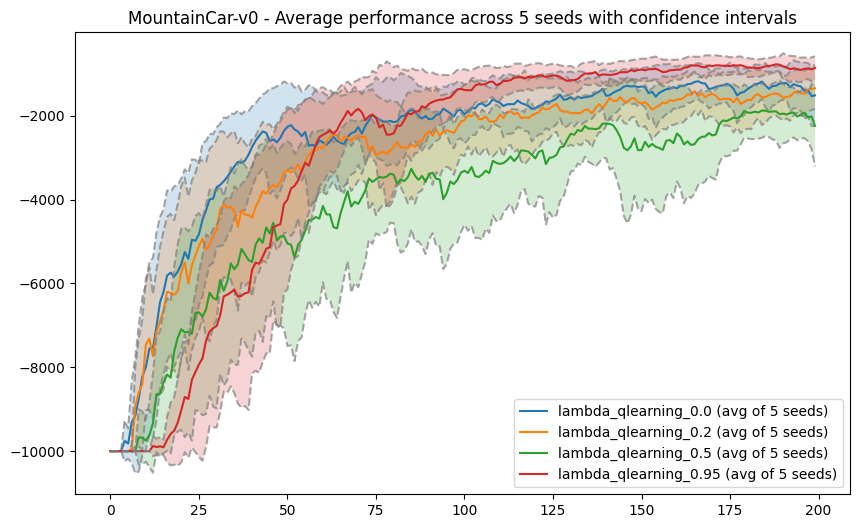

In [ ]:
evaluate_lambda_qlearning(lambda: Discretizer(gym.make("MountainCar-v0"), n_digits=2), n_episodes=200, n_seeds=5)

## N-step estimates in off-policy setting. Retrace algorithm. (3-5 points)

Implement Retrace algorithm and use it with Replay Buffer

## Understanding Retrace(λ)

Retrace(λ) is an off-policy reinforcement learning algorithm that combines the benefits of eligibility traces with importance sampling to provide stable and efficient learning from off-policy data.

### Key Features of Retrace

1. **Off-policy Learning**: Retrace can learn from data generated by any behavior policy, making it suitable for experience replay.

2. **Eligibility Traces**: Like TD(λ), Retrace uses eligibility traces to credit past state-action pairs, allowing for faster learning.

3. **Truncated Importance Sampling**: The key innovation in Retrace is the use of truncated importance sampling ratios ($\min(1, \frac{\pi(a|s)}{\mu(a|s)})$), which ensures the product of these ratios doesn't grow too large and cause variance issues.

### The Retrace Update Rule

Retrace maintains a running return estimate $Q^{ret}$ defined recursively:

$$Q^{ret}(s_t, a_t) = r_t + \gamma[(1-\alpha)Q(s_{t+1}, a_{t+1}) + \alpha(Q(s_{t+1}, a_{t+1}) + c_{t+1}\lambda\delta_{t+1})]$$

Where:
- $c_{t+1} = \min(1, \frac{\pi(a_{t+1}|s_{t+1})}{\mu(a_{t+1}|s_{t+1})})$ is the truncated importance sampling ratio
- $\delta_{t+1} = Q^{ret}(s_{t+1}, a_{t+1}) - Q(s_{t+1}, a_{t+1})$ is the TD error for the next state-action pair
- $\lambda$ is the trace decay parameter

This update effectively combines:
- Q-learning's off-policy capability
- SARSA's ability to use eligibility traces
- Stability through truncated importance sampling

### Advantages Over Traditional Methods

1. **Compared to Q-learning**: Retrace incorporates multi-step returns through eligibility traces, which can lead to faster convergence in many environments.

2. **Compared to SARSA(λ)**: Retrace is off-policy, so it can learn from exploratory actions without being affected by them.

3. **Compared to Importance Sampling Methods**: By truncating the importance ratios, Retrace avoids the high variance issues that plague many importance sampling approaches.

### Applications

Retrace is particularly well-suited for:
- Experience replay settings
- Learning from human demonstrations
- Any setting where on-policy data collection is expensive or impractical

## Task

Compare different Retrace methods: without Importance Sampling, with Importance Sampling, and with Retrace. Ensure the differences are noticeable. Test different training settings, such as collecting trajectories with one agent and using them to initialize Retrace. Collect several episodes using a uniform policy and use them to initialize the buffer. Analyze performance and convergence.

In [ ]:
def play_and_train_retrace(env, agent, replay, t_max, n_train_steps, trajectory_len):
    total_reward = 0.0
    s, _ = env.reset()
    replay._episodes.append([])

    for t in range(t_max):
        # Get action from agent
        a = agent.get_action(s)
        prob = agent.get_action_probability(s, a)

        next_s, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated

        replay._episodes[-1].append((s, a, r, next_s, done, prob))

        # Update state and total reward
        s = next_s
        total_reward += r

        if replay is not None and len(replay) > 0:
            for _ in range(n_train_steps):
                trajectory = replay.sample(max_trajectory_len=trajectory_len)  # whole trajectory
                agent.retrace_update(trajectory)

        if done:
            break

    return total_reward

In [ ]:
from collections import deque


class SequenceBuffer:
    def __init__(self, episode_capacity):
        self._episodes = deque(maxlen=episode_capacity)

    def __len__(self):
        return len(self._episodes)

    def add_sequence(self, sequence):
        self._episodes.append(sequence)

    def sample(self, max_trajectory_len=None):
        seq_idx = np.random.randint(0, len(self))
        sequence = self._episodes[seq_idx]

        if max_trajectory_len is None:
            return sequence

        start_idx = np.random.randint(0, max(len(sequence) - max_trajectory_len, 1))
        return sequence[start_idx : start_idx + max_trajectory_len]

In [ ]:
class RetraceAgent(QLearningAgent):
    def __init__(self, alpha, epsilon, discount, env, lambda_factor=0.9):
        super().__init__(alpha, epsilon, discount, env)
        self.lambda_factor = lambda_factor

    def get_action_probability(self, state, action):
        # <YOUR CODE HERE>

        # </END OF YOUR CODE>

    def retrace_update(self, trajectory):
        last_state, last_action, last_reward, last_next_state, last_done, last_behavior_prob = trajectory[-1]

        # <YOUR CODE HERE>
        G =

        # </END OF YOUR CODE>

        for state, action, reward, next_state, done, behavior_prob in reversed(trajectory[:-1]):
            # <YOUR CODE HERE>
            c =

            # </END OF YOUR CODE>
            if done:
                expected_Q = 0
            else:
                probs = [self.get_action_probability(state, action) for action in self.get_legal_actions(state)]
                # <YOUR CODE HERE>
                expected_Q =

                # </END OF YOUR CODE>

            # <YOUR CODE HERE>
            G =

            # </END OF YOUR CODE>

            # <YOUR CODE HERE>
            new_q_value =

            # </END OF YOUR CODE>
            self.set_qvalue(state, action, new_q_value)

Baseline : eps = 0.25 mean reward = -124.7
ExpReplay: eps = 0.25 mean reward = -153.9
Retrace: eps = 0.25 mean reward = -34.0


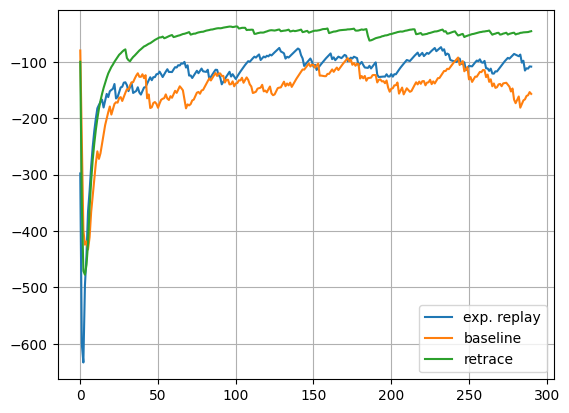

100%|██████████| 300/300 [01:02<00:00,  4.79it/s]


In [ ]:
env = gym.make("CliffWalking-v0")

agent_baseline = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99, env=env)

agent_replay = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99, env=env)
replay = ReplayBuffer(1000)

sequence_buffer = SequenceBuffer(1000)
retrace_agent = RetraceAgent(alpha=0.25, epsilon=0.25, discount=0.99, env=env, lambda_factor=0.9)

rewards_replay, rewards_baseline, rewards_retrace = [], [], []

t_max = 100
for i in trange(300):
    rewards_replay.append(play_and_train_with_replay(env, agent_replay, replay, t_max=t_max))
    rewards_baseline.append(play_and_train_with_replay(env, agent_baseline, replay=None, t_max=t_max))
    rewards_retrace.append(
        play_and_train_retrace(env, retrace_agent, sequence_buffer, t_max=t_max, trajectory_len=8, n_train_steps=32)
    )

    if i % 10 == 0:
        clear_output(True)
        print("Baseline : eps =", agent_replay.epsilon, "mean reward =", np.mean(rewards_baseline[-10:]))
        print("ExpReplay: eps =", agent_baseline.epsilon, "mean reward =", np.mean(rewards_replay[-10:]))
        print("Retrace: eps =", retrace_agent.epsilon, "mean reward =", np.mean(rewards_retrace[-10:]))
        plt.plot(moving_average(rewards_replay, span=50), label="exp. replay")
        plt.plot(moving_average(rewards_baseline, span=50), label="baseline")
        plt.plot(moving_average(rewards_retrace, span=50), label="retrace")
        plt.grid()
        plt.legend()
        plt.show()

**Bonus:** You can also analyze the performance of different agents with different hyperparameters across various environments. For the N-step bonus, it would be interesting to show how the variance and bias of Q-values depend on nn.


### Outro

We will use the code you just wrote extensively in the next week of our course.

__Next week__ we're gonna explore how q-learning and similar algorithms can be applied for large state spaces, with deep learning models to approximate the Q function.

However, __the code you've written__ for this week is already capable of solving many RL problems, and as an added benefit - it is very easy to detach. You can use Q-learning, SARSA and Experience Replay for any RL problems you want to solve - just thow 'em into a file and import the stuff you need.